In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns

In [3]:
from datetime import datetime, timedelta

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import VAR

In [5]:
from sklearn import metrics

In [6]:
# import sys
# !conda install --yes --prefix {sys.prefix} -c saravji pmdarima
import pmdarima as pm

In [7]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', sep=',')

In [8]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


Удаляем колонки согласно ТЗ:

In [9]:
df.drop(columns=['weather_description','weather_main','clouds_all','snow_1h','rain_1h'], axis=1, inplace=True)

In [10]:
df.head()

,holiday,temp,date_time,traffic_volume
0,None,288.28,2012-10-02 09:00:00,5545
1,None,289.36,2012-10-02 10:00:00,4516
2,None,289.58,2012-10-02 11:00:00,4767
3,None,290.13,2012-10-02 12:00:00,5026
4,None,291.14,2012-10-02 13:00:00,4918


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         48204 non-null  object 
 1   temp            48204 non-null  float64
 2   date_time       48204 non-null  object 
 3   traffic_volume  48204 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


In [12]:
df.shape

(48204, 4)

Убираем дубли, оставляя последнюю запись:

In [13]:
df.drop_duplicates(subset=['date_time'], keep='last', inplace=True)

In [14]:
df.shape

(40575, 4)

In [15]:
unique, counts = np.unique(df['date_time'], return_counts=True)
for key,value in dict(zip(unique, counts)).items():
    if value > 1:
        print(f'Количество записей даты: {key} - {value}')

Преобразуем колонку "date_time" в datetime, т.к. нужны вычисления по этим данным:

In [16]:
df['date_time'] =  pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

In [17]:
df.isnull().sum()

holiday           0
temp              0
date_time         0
traffic_volume    0
dtype: int64

Пропусков в данных нет. Сбрасываем индекс, т.к. мы удаляли дубликаты и индекс поплыл:

In [18]:
df = df.reset_index(drop=True)

Проверим есть ли неравномерность в срезах каждый час:

In [19]:
for index, row in df.iterrows():
    if index > 0:
        if (df.loc[index, ('date_time')] - df.loc[index - 1, ('date_time')]).seconds > 3600:
            print(f"{df.loc[index - 1, ('date_time')]} - {df.loc[index, ('date_time')]}")

2012-10-03 06:00:00 - 2012-10-03 08:00:00
2012-10-03 09:00:00 - 2012-10-03 12:00:00
2012-10-03 16:00:00 - 2012-10-03 18:00:00
2012-10-05 01:00:00 - 2012-10-05 03:00:00
2012-10-05 03:00:00 - 2012-10-05 05:00:00
2012-10-06 02:00:00 - 2012-10-06 04:00:00
2012-10-07 00:00:00 - 2012-10-07 03:00:00
2012-10-09 02:00:00 - 2012-10-09 04:00:00
2012-10-10 03:00:00 - 2012-10-10 06:00:00
2012-10-10 16:00:00 - 2012-10-10 18:00:00
2012-10-10 23:00:00 - 2012-10-11 01:00:00
2012-10-11 01:00:00 - 2012-10-11 03:00:00
2012-10-11 10:00:00 - 2012-10-11 14:00:00
2012-10-12 18:00:00 - 2012-10-12 23:00:00
2012-10-21 00:00:00 - 2012-10-21 08:00:00
2012-10-21 08:00:00 - 2012-10-21 17:00:00
2012-10-21 18:00:00 - 2012-10-21 22:00:00
2012-10-22 06:00:00 - 2012-10-22 10:00:00
2012-10-25 08:00:00 - 2012-10-25 10:00:00
2012-11-04 03:00:00 - 2012-11-04 05:00:00
2012-11-05 14:00:00 - 2012-11-05 16:00:00
2012-11-05 18:00:00 - 2012-11-05 20:00:00
2012-11-06 10:00:00 - 2012-11-06 12:00:00
2012-11-11 21:00:00 - 2012-11-11 2

2013-03-13 13:00:00 - 2013-03-13 15:00:00
2013-03-13 16:00:00 - 2013-03-13 18:00:00
2013-03-13 19:00:00 - 2013-03-13 21:00:00
2013-03-13 22:00:00 - 2013-03-14 00:00:00
2013-03-14 01:00:00 - 2013-03-14 03:00:00
2013-03-14 04:00:00 - 2013-03-14 06:00:00
2013-03-14 07:00:00 - 2013-03-14 09:00:00
2013-03-14 10:00:00 - 2013-03-14 12:00:00
2013-03-14 13:00:00 - 2013-03-14 15:00:00
2013-03-14 15:00:00 - 2013-03-14 18:00:00
2013-03-14 19:00:00 - 2013-03-14 21:00:00
2013-03-14 22:00:00 - 2013-03-15 00:00:00
2013-03-15 01:00:00 - 2013-03-15 03:00:00
2013-03-15 04:00:00 - 2013-03-15 07:00:00
2013-03-15 07:00:00 - 2013-03-15 09:00:00
2013-03-15 10:00:00 - 2013-03-15 12:00:00
2013-03-15 12:00:00 - 2013-03-15 15:00:00
2013-03-15 16:00:00 - 2013-03-15 18:00:00
2013-03-15 19:00:00 - 2013-03-15 21:00:00
2013-03-15 22:00:00 - 2013-03-16 00:00:00
2013-03-16 01:00:00 - 2013-03-16 03:00:00
2013-03-16 04:00:00 - 2013-03-16 06:00:00
2013-03-16 07:00:00 - 2013-03-16 09:00:00
2013-03-16 10:00:00 - 2013-03-16 1

2013-09-18 18:00:00 - 2013-09-18 20:00:00
2013-09-18 21:00:00 - 2013-09-18 23:00:00
2013-09-19 00:00:00 - 2013-09-19 02:00:00
2013-09-19 02:00:00 - 2013-09-19 04:00:00
2013-09-19 04:00:00 - 2013-09-19 07:00:00
2013-09-19 08:00:00 - 2013-09-19 11:00:00
2013-09-19 11:00:00 - 2013-09-19 13:00:00
2013-09-19 13:00:00 - 2013-09-19 16:00:00
2013-09-19 17:00:00 - 2013-09-19 19:00:00
2013-09-20 00:00:00 - 2013-09-20 02:00:00
2013-09-20 02:00:00 - 2013-09-20 04:00:00
2013-09-20 05:00:00 - 2013-09-20 08:00:00
2013-09-20 11:00:00 - 2013-09-20 13:00:00
2013-09-20 14:00:00 - 2013-09-20 17:00:00
2013-09-20 17:00:00 - 2013-09-20 19:00:00
2013-09-20 20:00:00 - 2013-09-20 22:00:00
2013-09-21 03:00:00 - 2013-09-21 05:00:00
2013-09-21 05:00:00 - 2013-09-21 08:00:00
2013-09-21 08:00:00 - 2013-09-21 19:00:00
2013-09-21 20:00:00 - 2013-09-21 22:00:00
2013-09-21 23:00:00 - 2013-09-22 01:00:00
2013-09-22 02:00:00 - 2013-09-22 08:00:00
2013-09-22 08:00:00 - 2013-09-22 10:00:00
2013-09-22 10:00:00 - 2013-09-22 1

2014-03-04 14:00:00 - 2014-03-04 20:00:00
2014-03-09 01:00:00 - 2014-03-09 03:00:00
2014-04-02 17:00:00 - 2014-04-02 19:00:00
2014-04-20 09:00:00 - 2014-04-20 12:00:00
2014-04-29 08:00:00 - 2014-05-04 05:00:00
2014-05-06 05:00:00 - 2014-05-06 10:00:00
2014-05-21 02:00:00 - 2014-05-21 04:00:00
2014-06-03 08:00:00 - 2014-06-03 11:00:00
2014-06-03 12:00:00 - 2014-06-03 14:00:00
2014-06-04 07:00:00 - 2014-06-04 12:00:00
2014-06-09 06:00:00 - 2014-06-09 08:00:00
2014-06-09 10:00:00 - 2014-06-09 12:00:00
2014-06-10 04:00:00 - 2014-06-10 14:00:00
2014-06-10 16:00:00 - 2014-06-10 18:00:00
2014-06-10 22:00:00 - 2014-06-11 00:00:00
2014-06-11 00:00:00 - 2014-06-11 02:00:00
2014-06-11 02:00:00 - 2014-06-11 07:00:00
2014-06-11 07:00:00 - 2014-06-11 12:00:00
2014-06-11 12:00:00 - 2014-06-11 15:00:00
2014-06-11 15:00:00 - 2014-06-11 18:00:00
2014-06-11 20:00:00 - 2014-06-11 22:00:00
2014-06-11 22:00:00 - 2014-06-12 01:00:00
2014-06-12 01:00:00 - 2014-06-12 06:00:00
2014-06-12 06:00:00 - 2014-06-12 1

2016-02-17 16:00:00 - 2016-02-17 18:00:00
2016-02-18 02:00:00 - 2016-02-18 05:00:00
2016-02-18 05:00:00 - 2016-02-18 07:00:00
2016-02-18 07:00:00 - 2016-02-18 09:00:00
2016-02-18 09:00:00 - 2016-02-18 11:00:00
2016-02-18 12:00:00 - 2016-02-18 14:00:00
2016-02-18 14:00:00 - 2016-02-18 16:00:00
2016-02-18 16:00:00 - 2016-02-18 18:00:00
2016-02-18 18:00:00 - 2016-02-18 20:00:00
2016-02-18 20:00:00 - 2016-02-18 22:00:00
2016-02-19 00:00:00 - 2016-02-19 03:00:00
2016-02-19 03:00:00 - 2016-02-19 05:00:00
2016-02-19 05:00:00 - 2016-02-19 07:00:00
2016-02-19 07:00:00 - 2016-02-19 09:00:00
2016-02-19 09:00:00 - 2016-02-19 11:00:00
2016-02-19 11:00:00 - 2016-02-19 13:00:00
2016-02-19 14:00:00 - 2016-02-19 17:00:00
2016-02-19 17:00:00 - 2016-02-19 19:00:00
2016-02-19 19:00:00 - 2016-02-19 21:00:00
2016-02-19 21:00:00 - 2016-02-19 23:00:00
2016-02-20 01:00:00 - 2016-02-20 03:00:00
2016-02-20 03:00:00 - 2016-02-20 05:00:00
2016-02-20 05:00:00 - 2016-02-20 07:00:00
2016-02-20 07:00:00 - 2016-02-20 0

2016-06-29 18:00:00 - 2016-06-29 20:00:00
2016-07-12 08:00:00 - 2016-07-12 10:00:00
2016-07-12 12:00:00 - 2016-07-12 14:00:00
2016-07-12 16:00:00 - 2016-07-12 18:00:00
2016-07-13 08:00:00 - 2016-07-13 10:00:00
2016-07-13 12:00:00 - 2016-07-13 14:00:00
2016-07-13 16:00:00 - 2016-07-13 18:00:00
2016-08-24 16:00:00 - 2016-08-24 18:00:00
2016-09-01 12:00:00 - 2016-09-01 16:00:00
2016-09-18 10:00:00 - 2016-09-18 13:00:00
2016-09-20 08:00:00 - 2016-09-20 10:00:00
2016-09-21 19:00:00 - 2016-09-21 21:00:00
2016-09-25 16:00:00 - 2016-09-25 18:00:00
2016-09-27 06:00:00 - 2016-09-27 08:00:00
2016-10-07 14:00:00 - 2016-10-07 16:00:00
2016-10-08 13:00:00 - 2016-10-08 15:00:00
2016-10-09 08:00:00 - 2016-10-09 10:00:00
2016-10-10 08:00:00 - 2016-10-10 10:00:00
2016-10-14 08:00:00 - 2016-10-14 10:00:00
2016-10-15 07:00:00 - 2016-10-15 09:00:00
2016-10-15 09:00:00 - 2016-10-15 11:00:00
2016-10-15 12:00:00 - 2016-10-15 14:00:00
2016-10-15 19:00:00 - 2016-10-15 21:00:00
2016-10-16 03:00:00 - 2016-10-16 0

Заполним пробелы в данных так, чтобы срез был каждый час:

In [20]:
for index, row in df.iterrows():
    if index > 0:
        if (df.loc[index, ('date_time')] - df.loc[index - 1, ('date_time')]).seconds > 3600:
            add_counter = int((df.loc[index, ('date_time')] - df.loc[index - 1, ('date_time')]).seconds / 3600) - 1
            for step in range(add_counter):
                line = pd.DataFrame({'holiday': None, 'date_time': df.loc[index - 1, ('date_time')] + timedelta(hours=step + 1)}, index=[df.shape[0] + step])
                df = pd.concat([df, line], ignore_index=True)

In [21]:
df.shape

(44395, 4)

Сотрируем по колонке "date_time" и сбрасываем индекс, т.к. вставляли новые строки:

In [22]:
df = df.sort_values(by=['date_time']).reset_index(drop=True)

Убедимся, что мы заполнили пробелы в срезах по времени и у нас теперь отсутствуют интервалы больше часа:

In [23]:
for index, row in df.iterrows():
    if index > 0:
        if (df.loc[index, ('date_time')] - df.loc[index - 1, ('date_time')]).seconds > 3600:
            print(f"{df.loc[index - 1, ('date_time')]} - {df.loc[index, ('date_time')]}")

Срезы данных теперь каждый час, заполним отсутствующие значения в них методом интерполяции:

In [24]:
df.isnull().sum()

holiday           3820
temp              3820
date_time            0
traffic_volume    3820
dtype: int64

In [25]:
for index, row in df.iterrows():
    if index > 0:
        if df.loc[index, ('holiday')] is None:
            df.loc[index, ('holiday')] = df.loc[index - 1, ('holiday')] if not df.loc[index - 1, ('holiday')] is None else df.loc[index + 3, ('holiday')]

In [26]:
df_interpolated = pd.DataFrame()

In [27]:
df_interpolated['date_time'] = df['date_time']
df_interpolated['holiday'] = df['holiday']
df_interpolated['temp'] = df[['temp']].interpolate()
df_interpolated['traffic_volume'] = df[['traffic_volume']].interpolate()

In [28]:
df_interpolated.head()

,date_time,holiday,temp,traffic_volume
0,2012-10-02 09:00:00,None,288.28,5545.0
1,2012-10-02 10:00:00,None,289.36,4516.0
2,2012-10-02 11:00:00,None,289.58,4767.0
3,2012-10-02 12:00:00,None,290.13,5026.0
4,2012-10-02 13:00:00,None,291.14,4918.0


Убеждаемся, что пропуски ликвидированы:

In [29]:
df_interpolated.isnull().sum()

date_time         0
holiday           0
temp              0
traffic_volume    0
dtype: int64

Преобразуем температуру в Кельвинах в привычные по Цельсию (есть несколько записей в январе-феврале с температурой в Кельвинах = 0 - т.е. абсолютный ноль, что ошибочно, удаляем значение и опять интерполируем):

In [30]:
for index, row in df_interpolated.iterrows():
    if  df_interpolated.loc[index, ('temp')] == 0.0:
        df_interpolated.loc[index, ('temp')] = np.nan
    df_interpolated['temp'] = df[['temp']].interpolate()
    df_interpolated.loc[index, ('temp')] = df_interpolated.loc[index, ('temp')] - 273.15

Добавляем признаки - номер дня недели, час, месяц, год, неделя:

In [31]:
df_interpolated['weekday'] = df_interpolated.date_time.dt.dayofweek
df_interpolated['hour'] = df_interpolated.date_time.dt.hour
df_interpolated['month'] = df_interpolated.date_time.dt.month
df_interpolated['year'] = df_interpolated.date_time.dt.year
df_interpolated['week'] = df_interpolated.date_time.dt.isocalendar().week

Смотрим сколько дней, выпадающих на праздники:

In [32]:
unique, counts = np.unique(df_interpolated['holiday'], return_counts=True)
airport_dict = dict(zip(unique, counts))
print(f'Количество наблюдений каждого праздника:')
for key, value in airport_dict.items():
    print(f'{key}: {value}')

Количество наблюдений каждого праздника:
Christmas Day: 5
Columbus Day: 7
Independence Day: 5
Labor Day: 5
Martin Luther King Jr Day: 3
Memorial Day: 5
New Years Day: 5
None: 44339
State Fair: 5
Thanksgiving Day: 6
Veterans Day: 5
Washingtons Birthday: 5


Праздничных дней мало, соотвественно их значениями можно пренебречь.
Посмотрим на диаграммы распределения признаков:

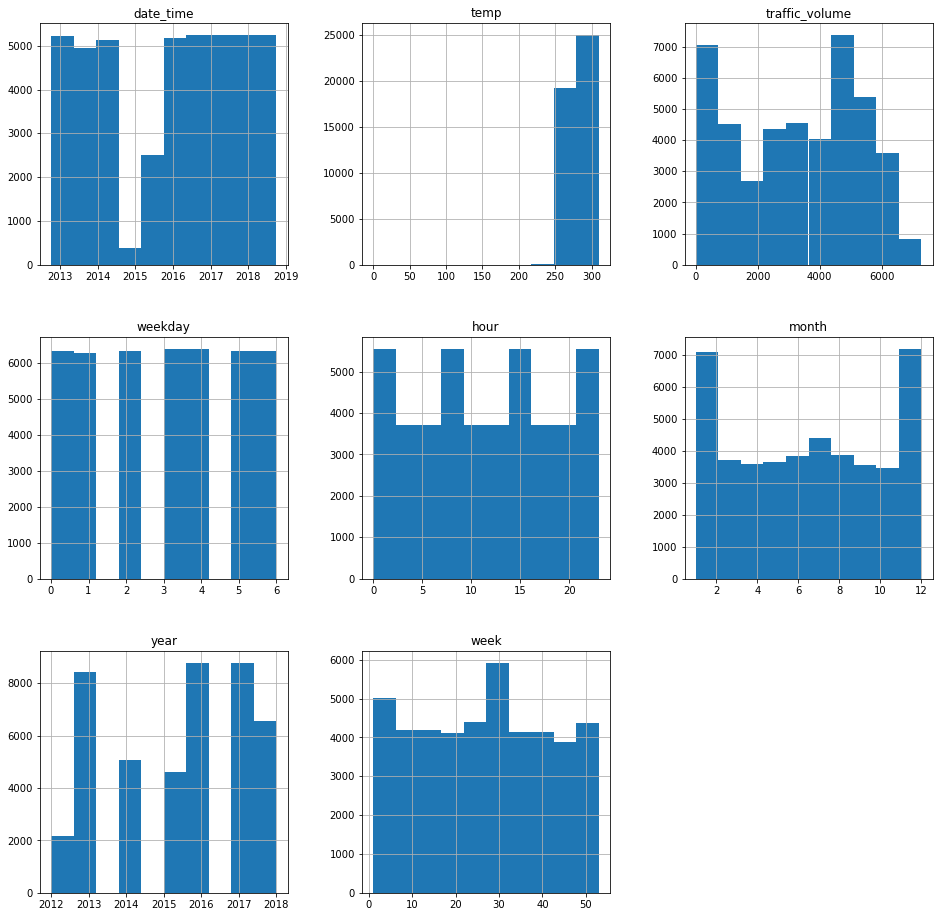

In [33]:
df_interpolated.hist(figsize=(16,16))
plt.show()

Отобразим матрицу коррелции числовых признаков:

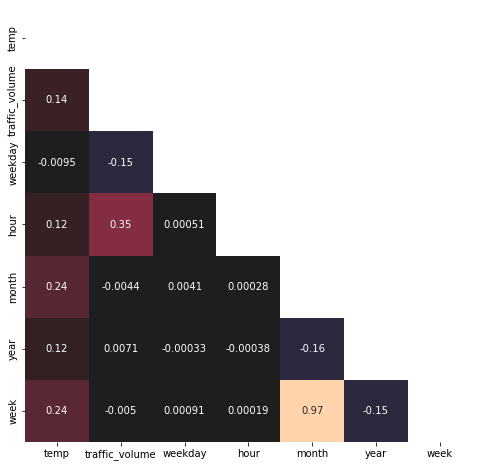

In [34]:
plt.figure(figsize=(8,8))

corr_matrix = df_interpolated.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

sns.heatmap(lower, annot=True, cbar=False, center=0);

Из всех числовых признаков целевая переменная наиболее сильно зависит от часа суток.

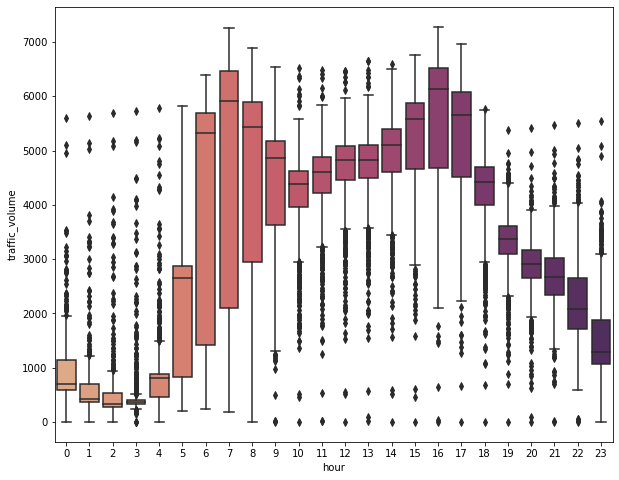

In [35]:
plt.figure(figsize=(10,8))
sns.boxplot(y='traffic_volume',x='hour', data=df_interpolated, palette='flare')
plt.show()

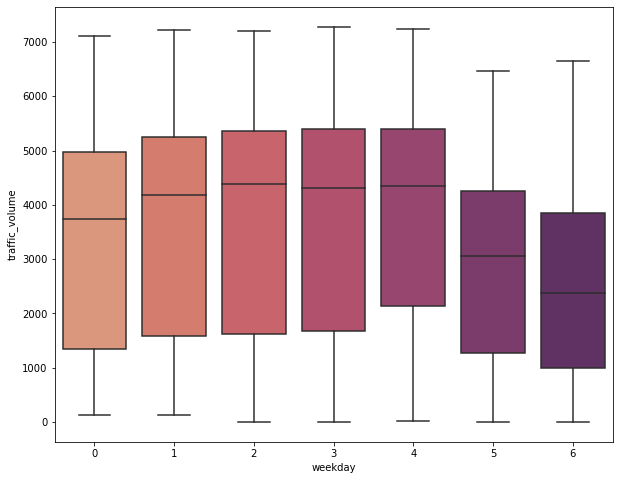

In [36]:
plt.figure(figsize=(10,8))
sns.boxplot(y='traffic_volume',x='weekday', data=df_interpolated, palette='flare')
plt.show()

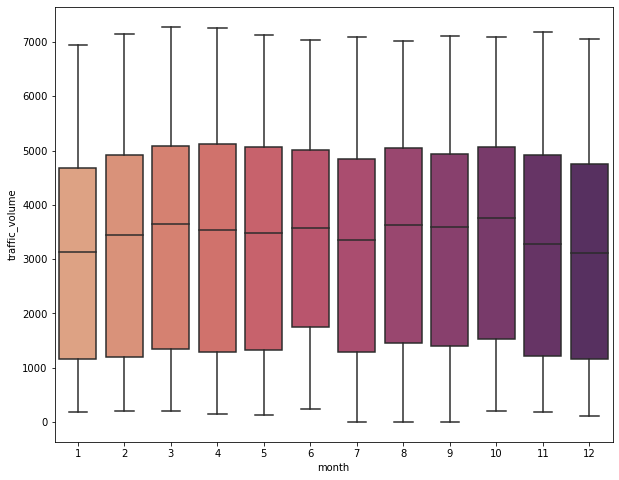

In [37]:
plt.figure(figsize=(10,8))
sns.boxplot(y='traffic_volume',x='month', data=df_interpolated, palette='flare')
plt.show()

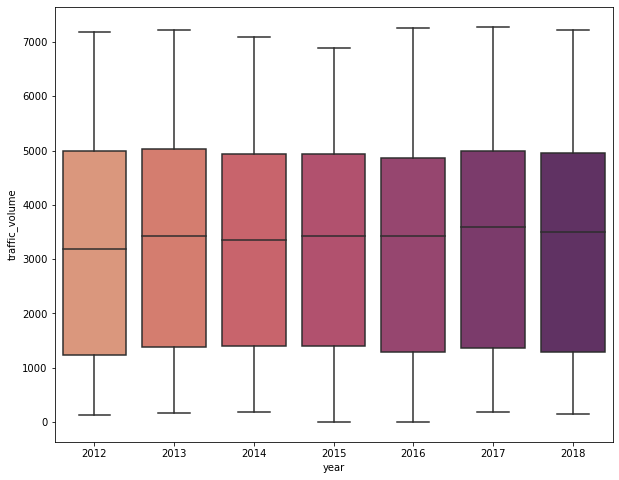

In [38]:
plt.figure(figsize=(10,8))
sns.boxplot(y='traffic_volume',x='year', data=df_interpolated, palette='flare')
plt.show()

Ищем день, предшествующий 14 днями последнему дню датасета:

In [39]:
df_interpolated.iloc[-1:]['date_time'] + timedelta(-13)

44394   2018-09-17 23:00:00
Name: date_time, dtype: datetime64[ns]

Тестовый набор данных будет - 14 дней после 16.09.22, тренировоночный набор - 30 дней перед тестовым, т.е. с 17.08.2018:

In [40]:
border_date = '2018-09-17 00:00:00'
start_date = datetime.strptime('2018-09-17 00:00:00', '%Y-%m-%d %H:%M:%S') + timedelta(-21)

In [41]:
df_train = df_interpolated.loc[(df_interpolated['date_time'] >= start_date.strftime('%Y-%m-%d %H:%M:%S')) & (df_interpolated['date_time'] < border_date)].copy()
df_test = df_interpolated.loc[df_interpolated['date_time'] >= border_date].copy()

In [42]:
df_train

,date_time,holiday,temp,traffic_volume,weekday,hour,month,year,week
43555,2018-08-27 00:00:00,None,296.84,666.0,0,0,8,2018,35
43556,2018-08-27 01:00:00,None,296.95,337.0,0,1,8,2018,35
43557,2018-08-27 02:00:00,None,296.98,292.0,0,2,8,2018,35
43558,2018-08-27 03:00:00,None,296.47,358.0,0,3,8,2018,35
43559,2018-08-27 04:00:00,None,296.34,933.0,0,4,8,2018,35
...,...,...,...,...,...,...,...,...,...
44054,2018-09-16 19:00:00,None,303.02,3400.0,6,19,9,2018,37
44055,2018-09-16 20:00:00,None,300.78,3092.0,6,20,9,2018,37
44056,2018-09-16 21:00:00,None,298.90,2623.0,6,21,9,2018,37
44057,2018-09-16 22:00:00,None,297.85,1725.0,6,22,9,2018,37


In [43]:
df_test

,date_time,holiday,temp,traffic_volume,weekday,hour,month,year,week
44059,2018-09-17 00:00:00,None,296.58,550.0,0,0,9,2018,38
44060,2018-09-17 01:00:00,None,296.19,280.0,0,1,9,2018,38
44061,2018-09-17 02:00:00,None,295.82,260.0,0,2,9,2018,38
44062,2018-09-17 03:00:00,None,295.83,344.0,0,3,9,2018,38
44063,2018-09-17 04:00:00,None,295.68,880.0,0,4,9,2018,38
...,...,...,...,...,...,...,...,...,...
44390,2018-09-30 19:00:00,None,283.45,3543.0,6,19,9,2018,39
44391,2018-09-30 20:00:00,None,282.76,2781.0,6,20,9,2018,39
44392,2018-09-30 21:00:00,None,282.73,2159.0,6,21,9,2018,39
44393,2018-09-30 22:00:00,None,282.09,1450.0,6,22,9,2018,39


In [44]:
# pd.plotting.register_matplotlib_converters()

In [45]:
df_train.index = df_train['date_time']
df_test.index = df_test['date_time']

In [46]:
df_train.index = pd.DatetimeIndex(df_train.index.values, freq=df_train.index.inferred_freq)
df_test.index = pd.DatetimeIndex(df_test.index.values, freq=df_test.index.inferred_freq)

Отобразим графики целевой переменной тренировочного и тестового наборов данных:

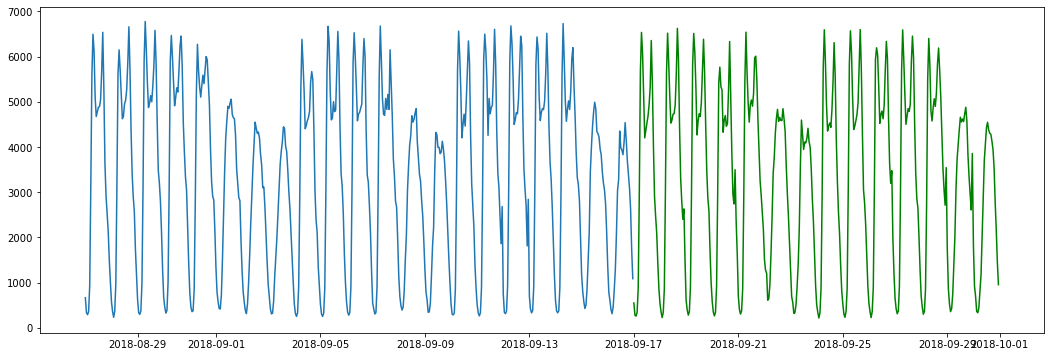

In [47]:
plt.figure(figsize=(18,6))
plt.plot(df_train.traffic_volume)
plt.plot(df_test.traffic_volume, color='green')
plt.show()

Наблюдается ярко выраженная недельная цикличность. Построим базовы прогноз методом скользящего среднего:

In [48]:
moving_average = df_train['traffic_volume'].rolling(window=7).mean()

In [49]:
def plot_two_series(actual_series, predicted_series):
    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot()
    ax.plot(actual_series, label='Оригинальный ряд')
    ax.plot(predicted_series, color='red', label='Предсказанный ряд')
    plt.legend(loc='upper left')
    plt.show()

Красным цветом отобразим график базового прогноза:

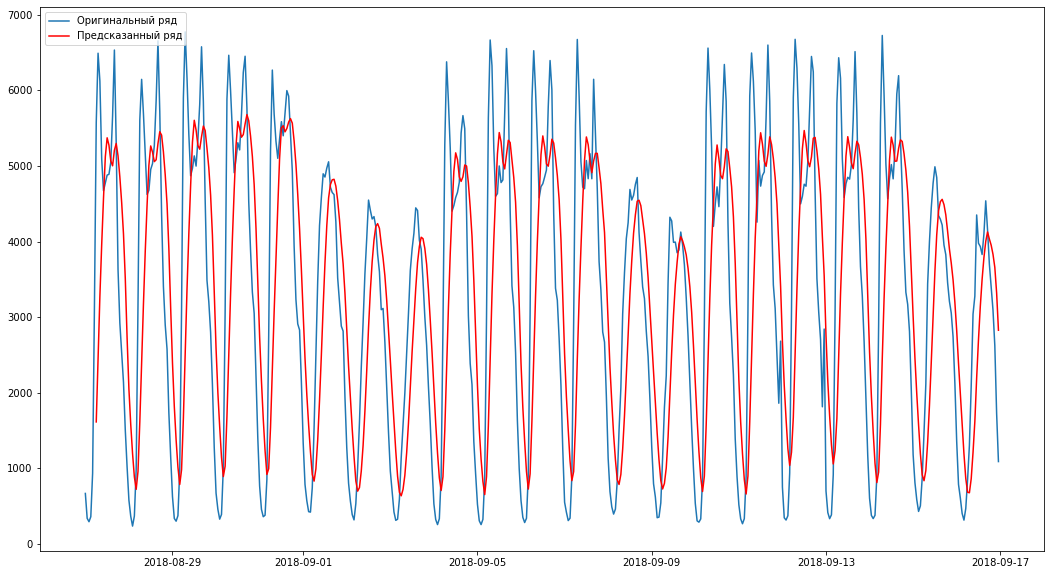

In [50]:
plot_two_series(df_train.traffic_volume, moving_average)

Построим базовый прогноз исходя из данных среднего значения целевой для каждого дня недели и часа суток:

In [51]:
wh_mean = df_train.groupby(['weekday', 'hour'])['traffic_volume'].mean()

In [52]:
df_wh_mean = wh_mean.to_frame()

In [53]:
df_wh_mean = df_wh_mean.reset_index()

In [54]:
df_wh_mean

,weekday,hour,traffic_volume
0,0,0,720.666667
1,0,1,444.666667
2,0,2,333.000000
3,0,3,332.333333
4,0,4,706.333333
...,...,...,...
163,6,19,3252.000000
164,6,20,2987.333333
165,6,21,2477.333333
166,6,22,1775.000000


Отобразим график базового прогноза, он состоит из 168 отсчетов - точка на каждый час недели:

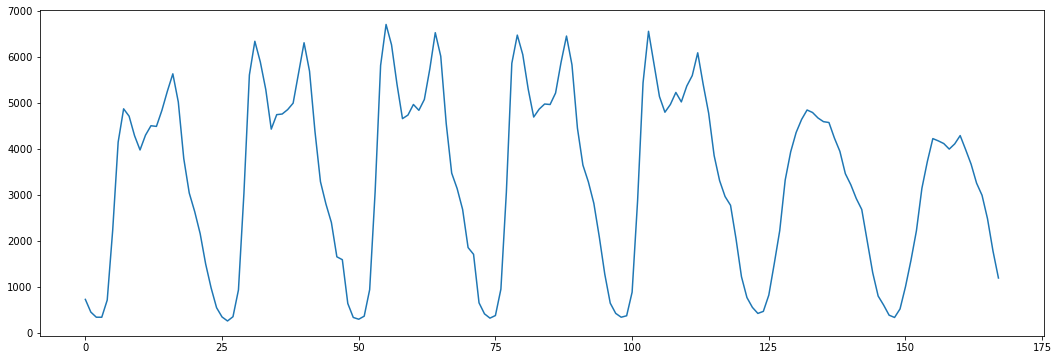

In [55]:
plt.figure(figsize=(18,6))
plt.plot(df_wh_mean.traffic_volume)
plt.show()

Напишем функцию для расчета метрик качества:

In [56]:
def error_metrics(y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2 = metrics.r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f'Метрики качества:')
    print(f'\tMAE: {mae}')
    print(f'\tMSE: {mse}')
    print(f'\tRMSE: {rmse}')
    print(f'\tR2: {r2}')
    print(f'\tMAPE: {mape}%')

Оценим качество предсказания базового прогноза для наших тестовых данных, для этого создадим датасет объединением тестового датасета и базового прогноза по номеру дня недели и часа суток:

In [57]:
df_test_ma = pd.merge(df_test, df_wh_mean,  how='left', left_on=['weekday','hour'], right_on = ['weekday','hour'])

In [58]:
error_metrics(df_test_ma['traffic_volume_x'], df_test_ma['traffic_volume_y'])

Метрики качества:
	MAE: 216.59821428571428
	MSE: 128636.93419312169
	RMSE: 358.6599143940143
	R2: 0.9666093747890279
	MAPE: 8.42051750332027%


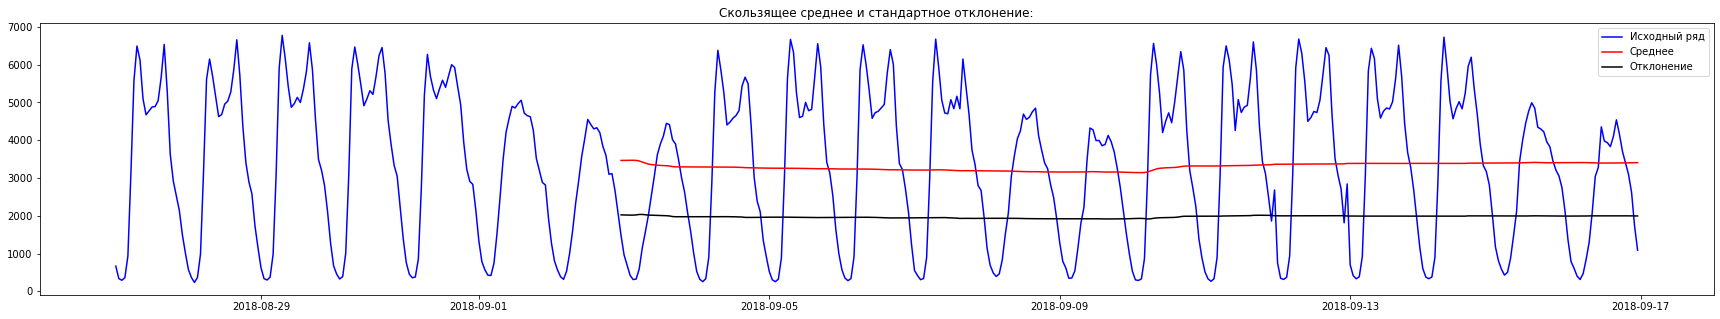

Тест Дикки-Фуллера::
p-value = 0.3614479386519712 анализируемый ряд нестационарный
Статистический тест      -1.838652
p-value                   0.361448
Кол-во лагов             24.000000
Количество точек        479.000000
Critical Value (1%)      -3.444076
Critical Value (5%)      -2.867593
Critical Value (10%)     -2.569994
dtype: float64


In [59]:
window = 24 * 7
cutoff = 0.05
rolmean = df_train.traffic_volume.rolling(window).mean()
rolstd = df_train.traffic_volume.rolling(window).std()

fig = plt.figure(figsize=(30, 5))
orig = plt.plot(df_train.traffic_volume, color='blue',label='Исходный ряд')
mean = plt.plot(rolmean, color='red', label='Среднее')
std = plt.plot(rolstd, color='black', label = 'Отклонение')
plt.legend(loc='best')
plt.title('Скользящее среднее и стандартное отклонение:')
plt.show()

print('Тест Дикки-Фуллера::')
dftest = adfuller(df_train.traffic_volume, autolag='AIC', maxlag = 24 )
dfoutput = pd.Series(dftest[0:4], index=['Статистический тест','p-value','Кол-во лагов','Количество точек'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < cutoff:
    print(f'p-value = {pvalue} анализируемый ряд стационарный')
else:
    print(f'p-value = {pvalue} анализируемый ряд нестационарный')

print(dfoutput)

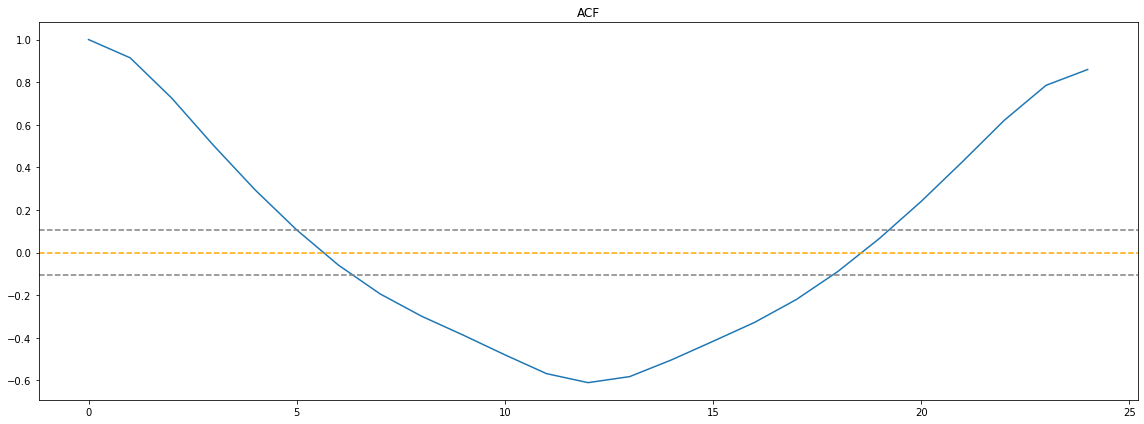

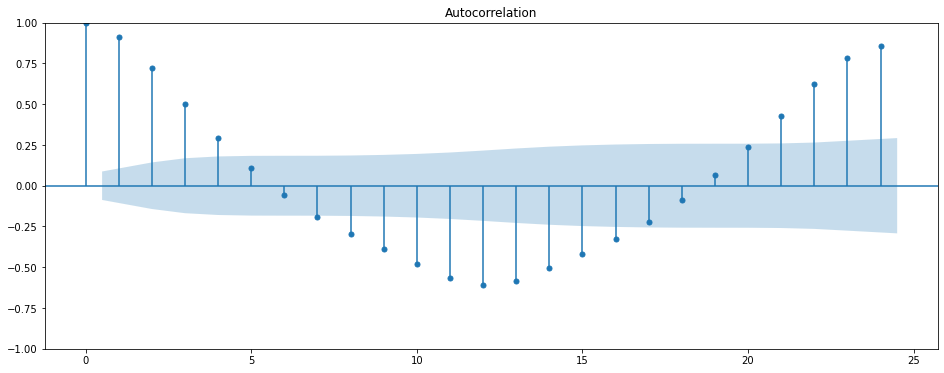

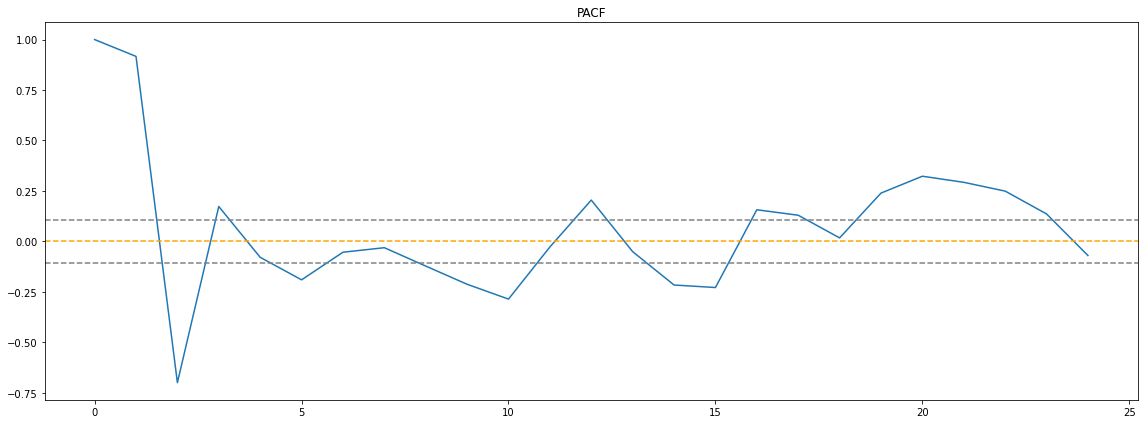

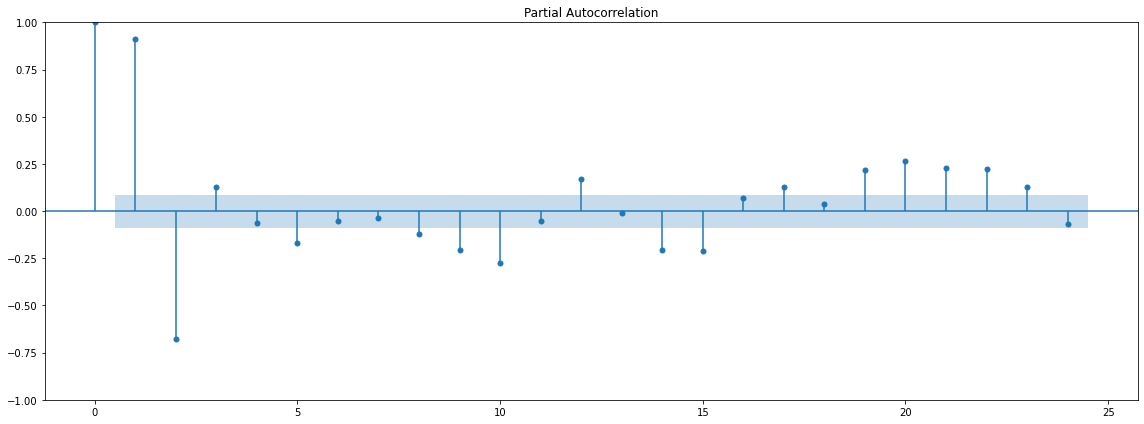

In [60]:
lag = 24
lag_pacf = pacf(df_train.traffic_volume, nlags=lag, method='ols')
lag_acf = acf(df_train.traffic_volume, nlags=lag)
plt.figure(figsize=(16,6))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='orange')
plt.axhline(y=-1.96/np.sqrt(len(df_test)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_test)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,6))
plot_acf(df_train.traffic_volume, ax=plt.gca(),lags=lag)
plt.show()

plt.figure(figsize=(16,6))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='orange')
plt.axhline(y=-1.96/np.sqrt(len(df_test)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_test)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,6))
plot_pacf(df_train.traffic_volume, ax=plt.gca(), lags=lag, method='ywm')
plt.tight_layout()
plt.show()

Исходя из графиков, параметры следующие:

In [61]:
p = 2
d = 0
q = 1

Построим модель ARIMA с данными параметрами:

In [62]:
model = sm.tsa.arima.ARIMA(df_train.traffic_volume, order=(p, d, q))  
results_arima = model.fit()

Отобразим прилегание модели:

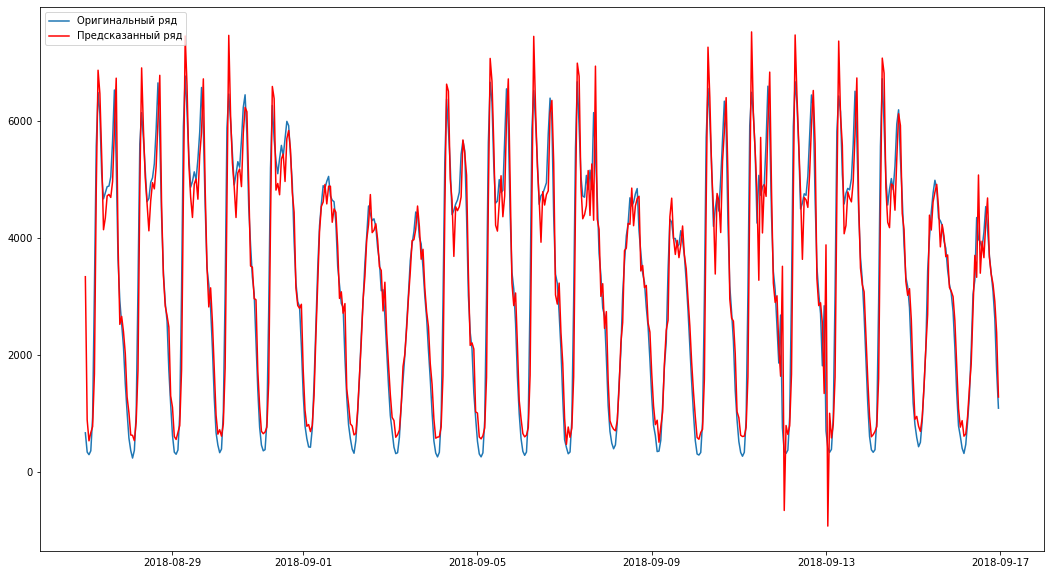

In [63]:
plot_two_series(df_train.traffic_volume, results_arima.fittedvalues)

Предскажем значения для тестового набора с помощью построенной модели:

In [64]:
def arima_forecast(current_value, p, d, q):
    model = sm.tsa.arima.ARIMA(current_value, order=(p, d, q))
    model_fit = model.fit()
    prediction = model_fit.forecast()[0]
    return prediction

In [65]:
values_list = df_test.traffic_volume.to_list()
pred_list = []

for point in range(len(values_list)):
    current_value =  df_test.traffic_volume[point]
    pred = arima_forecast(values_list, p,d,q)    
    pred_list.append(pred)
    values_list.append(current_value)  

arima_pred_df=pd.DataFrame(pred_list).set_index(df_test.index)

In [66]:
error_metrics(df_test.traffic_volume, pred_list)

Метрики качества:
	MAE: 420.34299453079717
	MSE: 339525.79742899106
	RMSE: 582.6884222541161
	R2: 0.9118684013847239
	MAPE: 26.39190834249841%


Визуализируем предсказанные значения:

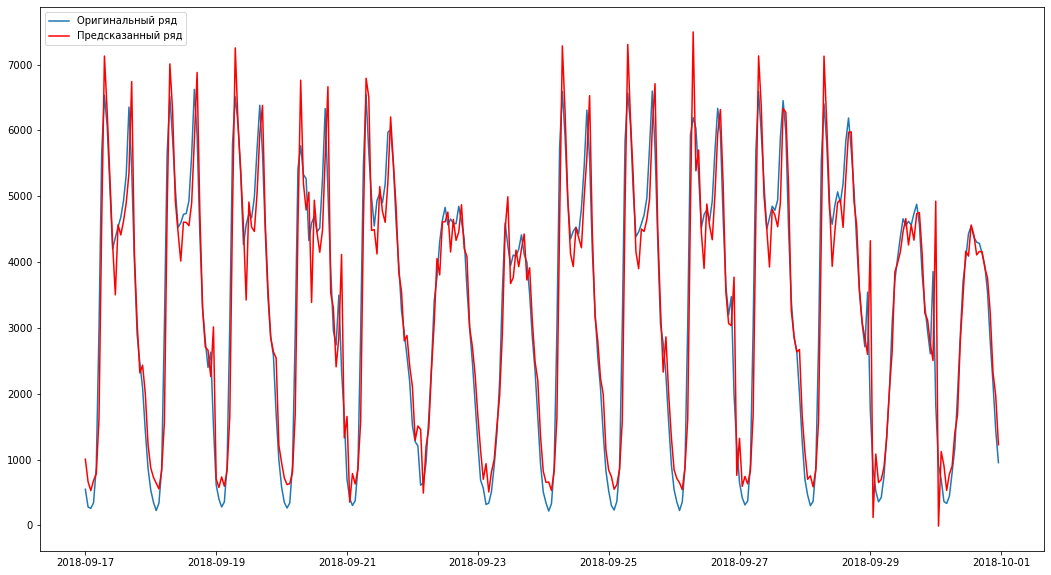

In [67]:
plot_two_series(df_test.traffic_volume, arima_pred_df)

In [67]:
model = pm.auto_arima(df_train.traffic_volume, test='adf',
                      start_p=2, start_q=1, 
                      max_p=3, max_q=3, max_P=3, max_Q=3, max_D=3,
                      start_P=0, D=None,
                      m=24 * 7, d=None, seasonal=True, 
                      trace=True, error_action='ignore', suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(0,0,1)[168] intercept   : AIC=inf, Time=31.09 sec
 ARIMA(0,0,0)(0,0,0)[168] intercept   : AIC=9085.295, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[168] intercept   : AIC=inf, Time=46.53 sec
 ARIMA(0,0,1)(0,0,1)[168] intercept   : AIC=inf, Time=42.59 sec
 ARIMA(0,0,0)(0,0,0)[168]             : AIC=9762.331, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[168] intercept   : AIC=inf, Time=38.37 sec
 ARIMA(0,0,0)(0,0,1)[168] intercept   : AIC=inf, Time=19.51 sec
 ARIMA(0,0,0)(1,0,1)[168] intercept   : AIC=inf, Time=47.99 sec
 ARIMA(1,0,0)(0,0,0)[168] intercept   : AIC=8162.215, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[168] intercept   : AIC=inf, Time=22.11 sec
 ARIMA(1,0,0)(1,0,1)[168] intercept   : AIC=inf, Time=65.04 sec
 ARIMA(2,0,0)(0,0,0)[168] intercept   : AIC=7825.378, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[168] intercept   : AIC=inf, Time=58.50 sec
 ARIMA(2,0,0)(0,0,1)[168] intercept   : AIC=inf, Time=27.79 sec
 ARIMA(2,0,0)(1,0,1)[168] intercept   : AIC=i

MemoryError: Unable to allocate 440. MiB for an array with shape (338, 338, 505) and data type float64

Строим модель с выбранными оптимальными параметрами:

In [68]:
model=sm.tsa.statespace.SARIMAX(df_train.traffic_volume,order=(2,0,1),seasonal_order=(1,0,0, 24 * 7))
results=model.fit()

In [89]:
def sarima_forecast(current_value):
    model = sm.tsa.statespace.SARIMAX(current_value,order=(2,0,1),seasonal_order=(1,0,0, 24), initialization='approximate_diffuse')
    model_fit = model.fit(maxiter=500, method='nm')
    prediction = model_fit.forecast()[0]
    return prediction

In [90]:
values_list = df_test.traffic_volume.to_list()
pred_list = []

for point in range(len(values_list)):
    current_value =  df_test.traffic_volume[point]
    pred = sarima_forecast(values_list)    
    pred_list.append(pred)
    values_list.append(current_value)  

sarima_pred_df=pd.DataFrame(pred_list).set_index(df_test.index)

Optimization terminated successfully.
         Current function value: 7.530971
         Iterations: 357
         Function evaluations: 582
Optimization terminated successfully.
         Current function value: 7.550389
         Iterations: 406
         Function evaluations: 656
Optimization terminated successfully.
         Current function value: 7.549409
         Iterations: 382
         Function evaluations: 631
Optimization terminated successfully.
         Current function value: 7.547764
         Iterations: 374
         Function evaluations: 616
Optimization terminated successfully.
         Current function value: 7.546645
         Iterations: 324
         Function evaluations: 525
Optimization terminated successfully.
         Current function value: 7.546399
         Iterations: 350
         Function evaluations: 565
Optimization terminated successfully.
         Current function value: 7.570528
         Iterations: 345
         Function evaluations: 558
Optimization termina

D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.593887
         Iterations: 469
         Function evaluations: 748


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.591150
         Iterations: 489
         Function evaluations: 802
Optimization terminated successfully.
         Current function value: 7.590903
         Iterations: 471
         Function evaluations: 765
Optimization terminated successfully.
         Current function value: 7.596863
         Iterations: 361
         Function evaluations: 591
Optimization terminated successfully.
         Current function value: 7.602021
         Iterations: 417
         Function evaluations: 665


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.586829
         Iterations: 464
         Function evaluations: 748


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.583466
         Iterations: 497
         Function evaluations: 793


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.578140
         Iterations: 442
         Function evaluations: 712


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.575577
         Iterations: 443
         Function evaluations: 721


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.573737
         Iterations: 458
         Function evaluations: 751
Optimization terminated successfully.
         Current function value: 7.577538
         Iterations: 462
         Function evaluations: 755
Optimization terminated successfully.
         Current function value: 7.576181
         Iterations: 472
         Function evaluations: 775


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.570631
         Iterations: 430
         Function evaluations: 691
Optimization terminated successfully.
         Current function value: 7.569324
         Iterations: 305
         Function evaluations: 499


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.567206
         Iterations: 427
         Function evaluations: 694
Optimization terminated successfully.
         Current function value: 7.566552
         Iterations: 331
         Function evaluations: 541


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.566050
         Iterations: 449
         Function evaluations: 725
Optimization terminated successfully.
         Current function value: 7.564687
         Iterations: 445
         Function evaluations: 720
Optimization terminated successfully.
         Current function value: 7.563824
         Iterations: 417
         Function evaluations: 663
Optimization terminated successfully.
         Current function value: 7.562744
         Iterations: 465
         Function evaluations: 752
Optimization terminated successfully.
         Current function value: 7.561421
         Iterations: 439
         Function evaluations: 706


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.558993
         Iterations: 484
         Function evaluations: 781


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.560486
         Iterations: 374
         Function evaluations: 611


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.555853
         Iterations: 420
         Function evaluations: 676
Optimization terminated successfully.
         Current function value: 7.554835
         Iterations: 487
         Function evaluations: 787
Optimization terminated successfully.
         Current function value: 7.553790
         Iterations: 405
         Function evaluations: 660
Optimization terminated successfully.
         Current function value: 7.552868
         Iterations: 342
         Function evaluations: 555
Optimization terminated successfully.
         Current function value: 7.551606
         Iterations: 362
         Function evaluations: 596
Optimization terminated successfully.
         Current function value: 7.552771
         Iterations: 357
         Function evaluations: 588
Optimization terminated successfully.
         Current function value: 7.551795
         Iterations: 329
         Function evaluations: 537
Optimization termina

D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.548677
         Iterations: 481
         Function evaluations: 772
Optimization terminated successfully.
         Current function value: 7.547686
         Iterations: 464
         Function evaluations: 760
Optimization terminated successfully.
         Current function value: 7.546423
         Iterations: 497
         Function evaluations: 799
Optimization terminated successfully.
         Current function value: 7.545822
         Iterations: 420
         Function evaluations: 688
Optimization terminated successfully.
         Current function value: 7.549507
         Iterations: 442
         Function evaluations: 722


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.549039
         Iterations: 436
         Function evaluations: 724


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.546496
         Iterations: 497
         Function evaluations: 814
Optimization terminated successfully.
         Current function value: 7.545357
         Iterations: 358
         Function evaluations: 581
Optimization terminated successfully.
         Current function value: 7.544407
         Iterations: 441
         Function evaluations: 716
Optimization terminated successfully.
         Current function value: 7.543977
         Iterations: 452
         Function evaluations: 742
Optimization terminated successfully.
         Current function value: 7.543122
         Iterations: 397
         Function evaluations: 655


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.550122
         Iterations: 446
         Function evaluations: 727
Optimization terminated successfully.
         Current function value: 7.548928
         Iterations: 362
         Function evaluations: 589
Optimization terminated successfully.
         Current function value: 7.548334
         Iterations: 373
         Function evaluations: 595


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.548647
         Iterations: 414
         Function evaluations: 682
Optimization terminated successfully.
         Current function value: 7.552958
         Iterations: 428
         Function evaluations: 698


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.550764
         Iterations: 440
         Function evaluations: 703


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.549015
         Iterations: 471
         Function evaluations: 770
Optimization terminated successfully.
         Current function value: 7.547843
         Iterations: 436
         Function evaluations: 700


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.565212
         Iterations: 476
         Function evaluations: 770


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.563893
         Iterations: 458
         Function evaluations: 741


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.560867
         Iterations: 464
         Function evaluations: 763


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.561562
         Iterations: 457
         Function evaluations: 749


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.552806
         Iterations: 420
         Function evaluations: 667


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.548762
         Iterations: 447
         Function evaluations: 717


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.546653
         Iterations: 427
         Function evaluations: 683


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.549718
         Iterations: 379
         Function evaluations: 617
Optimization terminated successfully.
         Current function value: 7.550868
         Iterations: 344
         Function evaluations: 561
Optimization terminated successfully.
         Current function value: 7.549794
         Iterations: 481
         Function evaluations: 785
Optimization terminated successfully.
         Current function value: 7.550255
         Iterations: 484
         Function evaluations: 789
Optimization terminated successfully.
         Current function value: 7.549452
         Iterations: 366
         Function evaluations: 581
Optimization terminated successfully.
         Current function value: 7.548788
         Iterations: 291
         Function evaluations: 477
Optimization terminated successfully.
         Current function value: 7.547916
         Iterations: 412
         Function evaluations: 663


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.547064
         Iterations: 415
         Function evaluations: 677


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.554399
         Iterations: 385
         Function evaluations: 630


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.570352
         Iterations: 418
         Function evaluations: 683
Optimization terminated successfully.
         Current function value: 7.572585
         Iterations: 359
         Function evaluations: 589
Optimization terminated successfully.
         Current function value: 7.571718
         Iterations: 290
         Function evaluations: 482
Optimization terminated successfully.
         Current function value: 7.575531
         Iterations: 311
         Function evaluations: 502
Optimization terminated successfully.
         Current function value: 7.574561
         Iterations: 353
         Function evaluations: 578
Optimization terminated successfully.
         Current function value: 7.573614
         Iterations: 433
         Function evaluations: 708
Optimization terminated successfully.
         Current function value: 7.574732
         Iterations: 327
         Function evaluations: 529


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.576155
         Iterations: 388
         Function evaluations: 634
Optimization terminated successfully.
         Current function value: 7.576294
         Iterations: 442
         Function evaluations: 716


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.573526
         Iterations: 421
         Function evaluations: 683
Optimization terminated successfully.
         Current function value: 7.572529
         Iterations: 361
         Function evaluations: 594
Optimization terminated successfully.
         Current function value: 7.571525
         Iterations: 420
         Function evaluations: 677


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.567608
         Iterations: 450
         Function evaluations: 722
Optimization terminated successfully.
         Current function value: 7.568017
         Iterations: 282
         Function evaluations: 475
Optimization terminated successfully.
         Current function value: 7.567649
         Iterations: 317
         Function evaluations: 529
Optimization terminated successfully.
         Current function value: 7.566651
         Iterations: 377
         Function evaluations: 610
Optimization terminated successfully.
         Current function value: 7.565925
         Iterations: 494
         Function evaluations: 797
Optimization terminated successfully.
         Current function value: 7.564973
         Iterations: 380
         Function evaluations: 615
Optimization terminated successfully.
         Current function value: 7.563989
         Iterations: 339
         Function evaluations: 548
Optimization termina

D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.557186
         Iterations: 445
         Function evaluations: 713
Optimization terminated successfully.
         Current function value: 7.556217
         Iterations: 352
         Function evaluations: 577
Optimization terminated successfully.
         Current function value: 7.555275
         Iterations: 451
         Function evaluations: 720
Optimization terminated successfully.
         Current function value: 7.554311
         Iterations: 299
         Function evaluations: 495
Optimization terminated successfully.
         Current function value: 7.553365
         Iterations: 328
         Function evaluations: 548
Optimization terminated successfully.
         Current function value: 7.552426
         Iterations: 338
         Function evaluations: 552
Optimization terminated successfully.
         Current function value: 7.551489
         Iterations: 345
         Function evaluations: 574
Optimization termina

D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.550540
         Iterations: 418
         Function evaluations: 667


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.551144
         Iterations: 485
         Function evaluations: 771


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.545945
         Iterations: 457
         Function evaluations: 739


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.544300
         Iterations: 462
         Function evaluations: 751


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.545492
         Iterations: 397
         Function evaluations: 649


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.548638
         Iterations: 331
         Function evaluations: 545
Optimization terminated successfully.
         Current function value: 7.547734
         Iterations: 384
         Function evaluations: 625
Optimization terminated successfully.
         Current function value: 7.546817
         Iterations: 422
         Function evaluations: 677
Optimization terminated successfully.
         Current function value: 7.545902
         Iterations: 373
         Function evaluations: 604
Optimization terminated successfully.
         Current function value: 7.545075
         Iterations: 447
         Function evaluations: 744


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.541852
         Iterations: 475
         Function evaluations: 764
Optimization terminated successfully.
         Current function value: 7.540950
         Iterations: 485
         Function evaluations: 791


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.540190
         Iterations: 414
         Function evaluations: 678
Optimization terminated successfully.
         Current function value: 7.539293
         Iterations: 483
         Function evaluations: 763


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.537978
         Iterations: 495
         Function evaluations: 796


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.536810
         Iterations: 379
         Function evaluations: 614
Optimization terminated successfully.
         Current function value: 7.535926
         Iterations: 430
         Function evaluations: 716


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.531033
         Iterations: 455
         Function evaluations: 734


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.526529
         Iterations: 445
         Function evaluations: 723


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.526522
         Iterations: 493
         Function evaluations: 805


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.524826
         Iterations: 494
         Function evaluations: 806
Optimization terminated successfully.
         Current function value: 7.524784
         Iterations: 416
         Function evaluations: 683
Optimization terminated successfully.
         Current function value: 7.532832
         Iterations: 301
         Function evaluations: 504


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.549893
         Iterations: 476
         Function evaluations: 751


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.553330
         Iterations: 375
         Function evaluations: 609
Optimization terminated successfully.
         Current function value: 7.552530
         Iterations: 354
         Function evaluations: 581
Optimization terminated successfully.
         Current function value: 7.551696
         Iterations: 394
         Function evaluations: 640
Optimization terminated successfully.
         Current function value: 7.550963
         Iterations: 378
         Function evaluations: 631
Optimization terminated successfully.
         Current function value: 7.550142
         Iterations: 444
         Function evaluations: 729


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.549256
         Iterations: 467
         Function evaluations: 772
Optimization terminated successfully.
         Current function value: 7.548505
         Iterations: 457
         Function evaluations: 742


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.547882
         Iterations: 498
         Function evaluations: 814


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.545684
         Iterations: 447
         Function evaluations: 723
Optimization terminated successfully.
         Current function value: 7.546803
         Iterations: 435
         Function evaluations: 724
Optimization terminated successfully.
         Current function value: 7.546118
         Iterations: 478
         Function evaluations: 786
Optimization terminated successfully.
         Current function value: 7.545360
         Iterations: 380
         Function evaluations: 616


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.543885
         Iterations: 360
         Function evaluations: 587
Optimization terminated successfully.
         Current function value: 7.543144
         Iterations: 345
         Function evaluations: 559
Optimization terminated successfully.
         Current function value: 7.542375
         Iterations: 380
         Function evaluations: 603
Optimization terminated successfully.
         Current function value: 7.541678
         Iterations: 453
         Function evaluations: 726


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 7.540345
         Iterations: 392
         Function evaluations: 641
Optimization terminated successfully.
         Current function value: 7.540013
         Iterations: 470
         Function evaluations: 752
Optimization terminated successfully.
         Current function value: 7.539249
         Iterations: 388
         Function evaluations: 628
Optimization terminated successfully.
         Current function value: 7.538627
         Iterations: 490
         Function evaluations: 789
Optimization terminated successfully.
         Current function value: 7.538001
         Iterations: 461
         Function evaluations: 755
Optimization terminated successfully.
         Current function value: 7.537350
         Iterations: 393
         Function evaluations: 652
Optimization terminated successfully.
         Current function value: 7.536666
         Iterations: 410
         Function evaluations: 661
Optimization termina

D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\Dev\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [91]:
error_metrics(df_test.traffic_volume, pred_list)

Метрики качества:
	MAE: 304.85578936040474
	MSE: 214813.306580517
	RMSE: 463.47956436127475
	R2: 0.9442403485798931
	MAPE: 15.398983657945319%


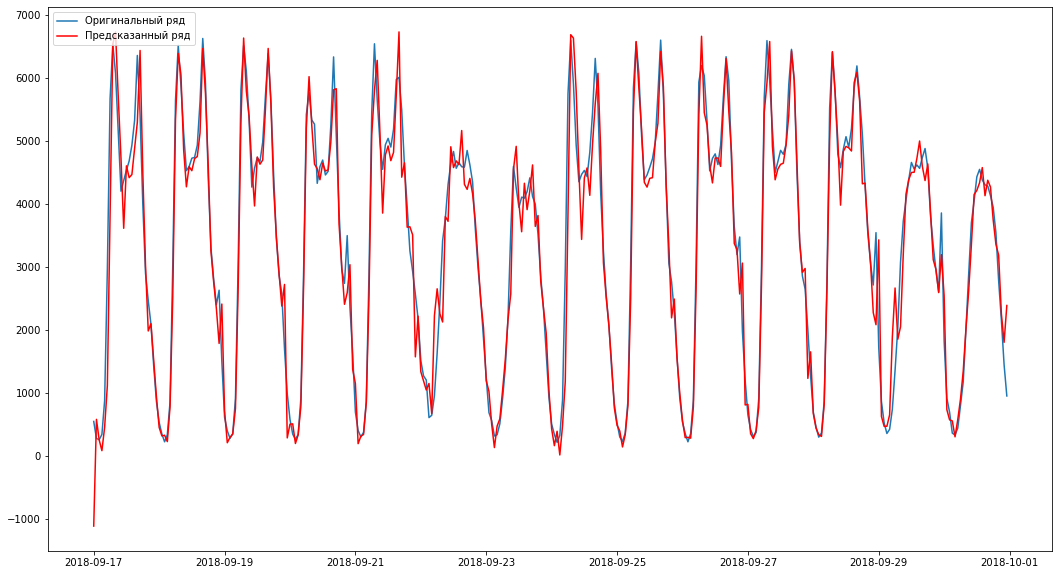

In [92]:
plot_two_series(df_test.traffic_volume, sarima_pred_df)

In [294]:
error_metrics(df_test.traffic_volume, pred_list)

Метрики качества:
	MAE: 303.2483721590228
	MSE: 219668.19337111307
	RMSE: 468.68773546052284
	R2: 0.942007623989981
	MAPE: 15.461092147142136%


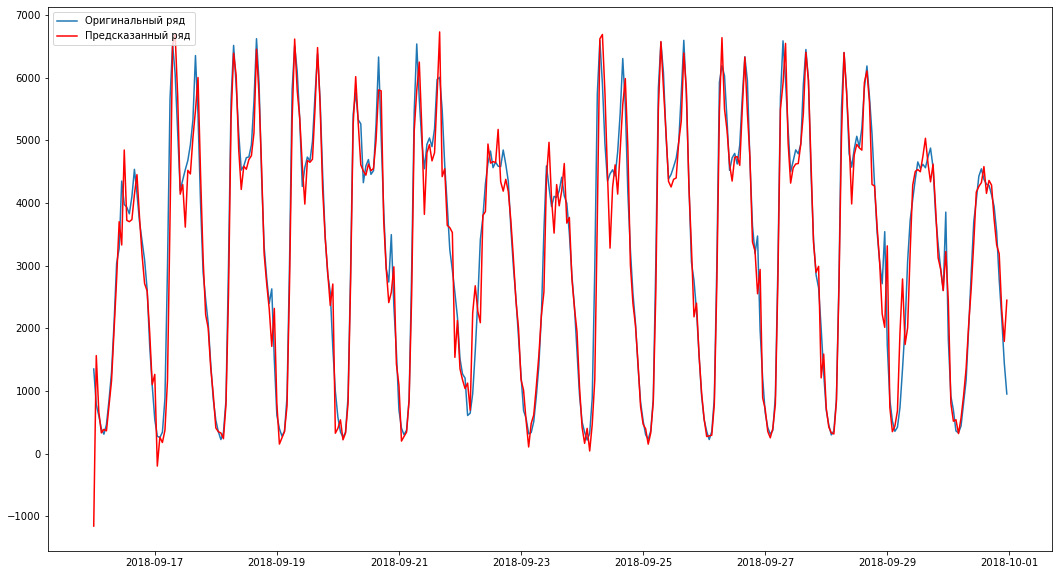

In [295]:
plot_two_series(df_test.traffic_volume, sarima_pred_df)